In [3]:
import shap
import numpy as np
import pandas as pd
from shap import TreeExplainer
import matplotlib.pyplot as plt
from lightgbm import plot_importance
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve

import preprocess
import train_model
import feature_engineering

# Run Model

In [4]:
%%time
# pre process
rawdata = preprocess.preprocess()

# feature engineering
feature_engineering_response = feature_engineering.presplit_feature_engineering(rawdata)

# train model
train_cols = list(feature_engineering_response.lag_features_organizer.all_new_features.union(
feature_engineering_response.moving_averages_features_organizer.all_new_features
).union(feature_engineering_response.dates_diff_organizer.all_new_features)) + feature_engineering.FEATURES_TO_LAG


model_artifacts = train_model.model_exe(
    feature_engineering_response.enriched_data,
    train_cols,
    1.5
)

Columns (0,1,3,5,6,7,8,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 35 rounds
[50]	valid_0's binary_logloss: 0.150526
[100]	valid_0's binary_logloss: 0.139422
[150]	valid_0's binary_logloss: 0.134959
[200]	valid_0's binary_logloss: 0.132795
[250]	valid_0's binary_logloss: 0.131627
[300]	valid_0's binary_logloss: 0.130926
[350]	valid_0's binary_logloss: 0.130466
[400]	valid_0's binary_logloss: 0.130168
[450]	valid_0's binary_logloss: 0.129915
[500]	valid_0's binary_logloss: 0.129728
Did not meet early stopping. Best iteration is

In [11]:
model_artifacts.optimal_threshold

0.15822602642072126

# Analyze model performance on validation

In [5]:
train_cols = model_artifacts.train_cols
X_validation = model_artifacts.splited_data.validation['X']
y_validation = model_artifacts.splited_data.validation['y']
y_validation_proba = model_artifacts.estimator.predict_proba(X_validation[train_cols])[:,1]
y_validation_pred = np.where(y_validation_proba>=model_artifacts.optimal_threshold, 1, 0)

X_train = model_artifacts.splited_data.train['X']
y_train = model_artifacts.splited_data.train['y']
y_train_proba = model_artifacts.estimator.predict_proba(X_train[train_cols])[:,1]
y_train_pred = np.where(y_train_proba>=model_artifacts.optimal_threshold, 1, 0)

In [6]:
print(f'***VALIDATION***')
print(f'The model accuracy is: {accuracy_score(y_validation, y_validation_pred)}')
print(f'The model ROC-AUC score is: {roc_auc_score(y_validation, y_validation_pred)}')
print(f'The model F1 score is: {f1_score(y_validation, y_validation_pred)}')
print(f'The model recall score is: {recall_score(y_validation, y_validation_pred)}')
print(f'The model precision score is: {precision_score(y_validation, y_validation_pred)}\n')

conf_mat = confusion_matrix(y_validation, y_validation_pred) 
display(pd.DataFrame(conf_mat))

print(f'\n***TRAIN***')
print(f'The model accuracy is: {accuracy_score(y_train, y_train_pred)}')
print(f'The model ROC-AUC score is: {roc_auc_score(y_train, y_train_pred)}')
print(f'The model F1 score is: {f1_score(y_train, y_train_pred)}')
print(f'The model recall score is: {recall_score(y_train, y_train_pred)}')
print(f'The model precision score is: {precision_score(y_train, y_train_pred)}\n')

conf_mat = confusion_matrix(y_train, y_train_pred) 
display(pd.DataFrame(conf_mat))

***VALIDATION***
The model accuracy is: 0.9280568081687659
The model ROC-AUC score is: 0.7265045033035336
The model F1 score is: 0.20321469575200918
The model recall score is: 0.5175438596491229
The model precision score is: 0.12642857142857142



,0,1
0,17728,1223
1,165,177



***TRAIN***
The model accuracy is: 0.8447410198175479
The model ROC-AUC score is: 0.7485006341524345
The model F1 score is: 0.37342897431181415
The model recall score is: 0.6358701325816891
The model precision score is: 0.2643319012281387



,0,1
0,105120,16952
1,3488,6091


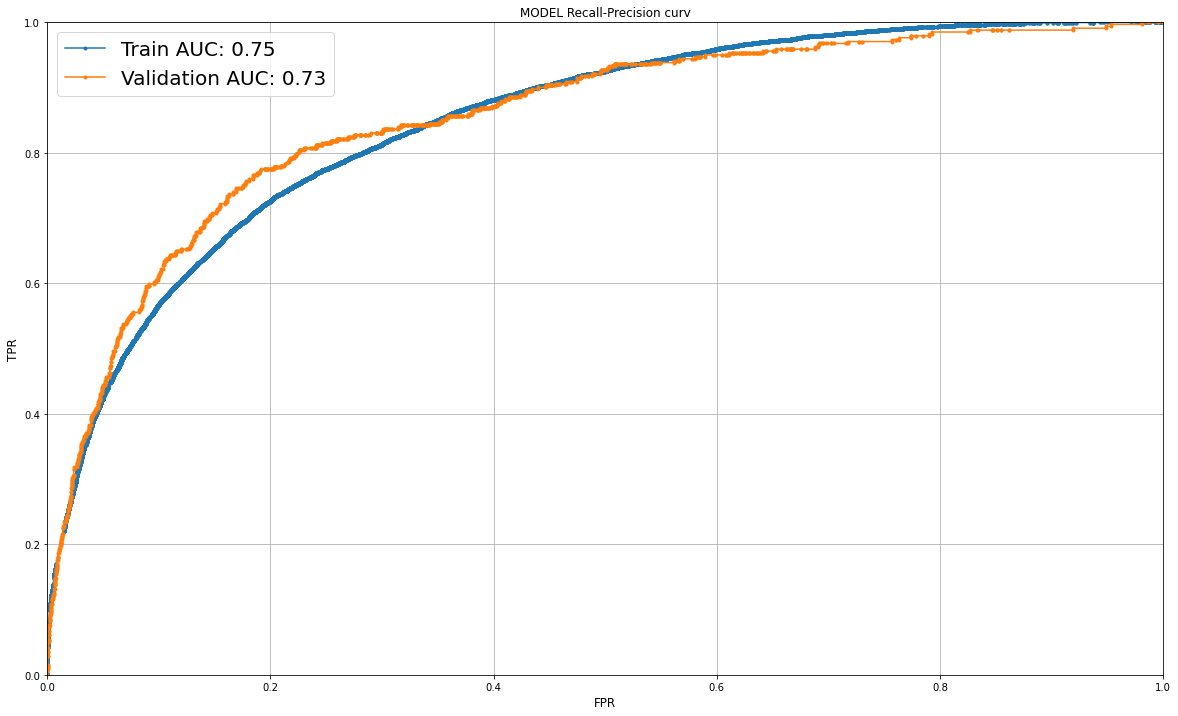

In [7]:
fpr_validation,tpr_validation,_ = roc_curve(y_validation, y_validation_proba)
fpr_train,tpr_train,_ = roc_curve(y_train, y_train_proba)

plt.figure(figsize=(20, 12))
plt.grid()
plt.plot(fpr_train,tpr_train, marker='.', label=f"Train AUC: {round(roc_auc_score(y_train, y_train_pred), 2)}")
plt.plot(fpr_validation,tpr_validation, marker='.', label=f"Validation AUC: {round(roc_auc_score(y_validation, y_validation_pred), 2)}")
plt.title('MODEL Recall-Precision curv')
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR', fontsize=12)
plt.legend(fontsize=20)
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

# Interpritate model

In [8]:
explainer = TreeExplainer(model_artifacts.estimator)
shap_values = explainer.shap_values(X_validation[train_cols])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


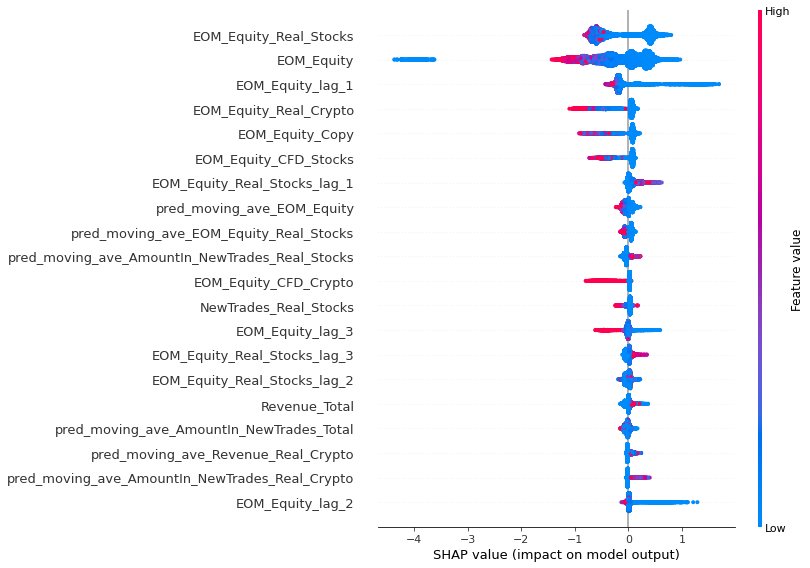

In [9]:
shap.summary_plot(shap_values[1], X_validation[train_cols])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

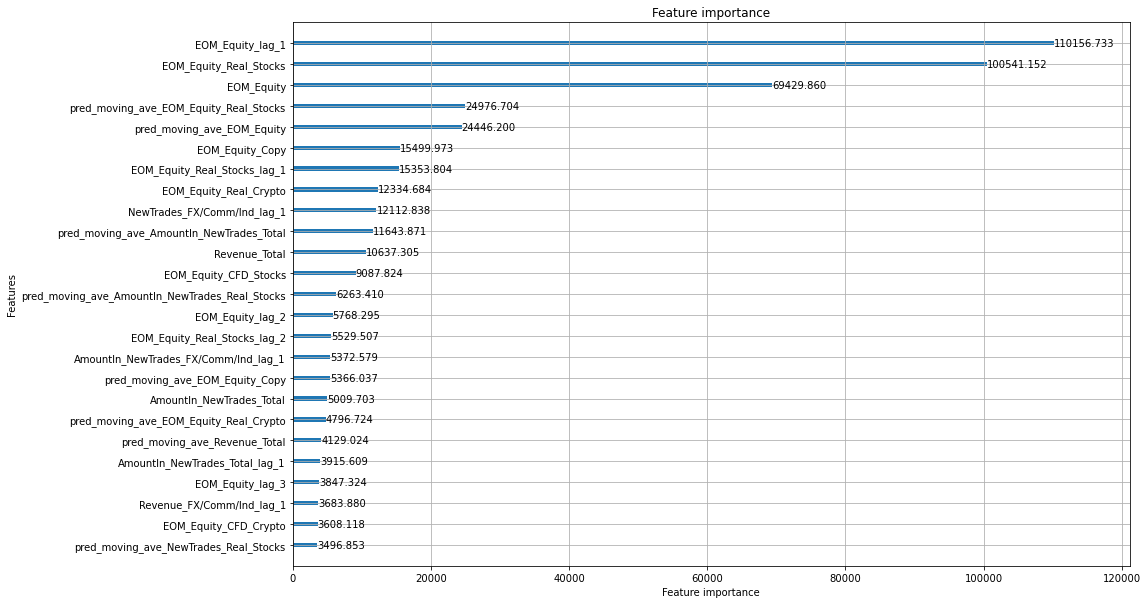

In [10]:
plot_importance(
    model_artifacts.estimator, 
    max_num_features=25, 
    figsize=(15, 10),
    importance_type='gain'
)